# Mary's Model

In [411]:
# packages
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from scipy.stats import zscore, randint

# feature selection
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_selection import f_classif

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso, Ridge

from xgboost import XGBRegressor

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [113]:
# Specify the absolute path to your CSV file
file_path = "/Users/mariegondeck/Desktop/air_pollution_prediction/data/Train.csv"

# Check if the file exists
print(os.path.exists(file_path))

# Read the CSV file
df = pd.read_csv(file_path, sep=',')

True


**Delete Columns**

• Deleting uneccessary metadata and target columns\
• Delete columns with too many missing values\
• Keep the rest, as the features are weightes with KBest later 


In [293]:
columns_to_delete = [#removing metadata and redundant target columns
                     'Place_ID X Date', 
                     'target_min', 
                     'target_max',
                     'target_variance', 
                     'target_count',
                     #delete columns with nearly 80% missing data
                     'L3_CH4_aerosol_optical_depth', 
                     'L3_CH4_sensor_azimuth_angle',     
                     'L3_CH4_sensor_zenith_angle',      
                     'L3_CH4_solar_azimuth_angle',      
                     'L3_CH4_solar_zenith_angle',
                     'L3_CH4_CH4_column_volume_mixing_ratio_dry_air',
                     'L3_CH4_aerosol_height']

df_reduced = df.drop(columns = columns_to_delete, axis = 1)

**Split test data in 80% train and 20% test data**

In [294]:
RSEED = 9 

# Define x/y
X = df_reduced 
y = np.array(X.pop('target'))

# split train/test data
train_X, test_X, train_y, test_y = train_test_split(X, y,
                                                    test_size = 0.2, 
                                                    random_state = RSEED)

**Change data types or apply transformations**

In [295]:
X['Date'] = pd.to_datetime(X['Date'])

**Check distribution of features**


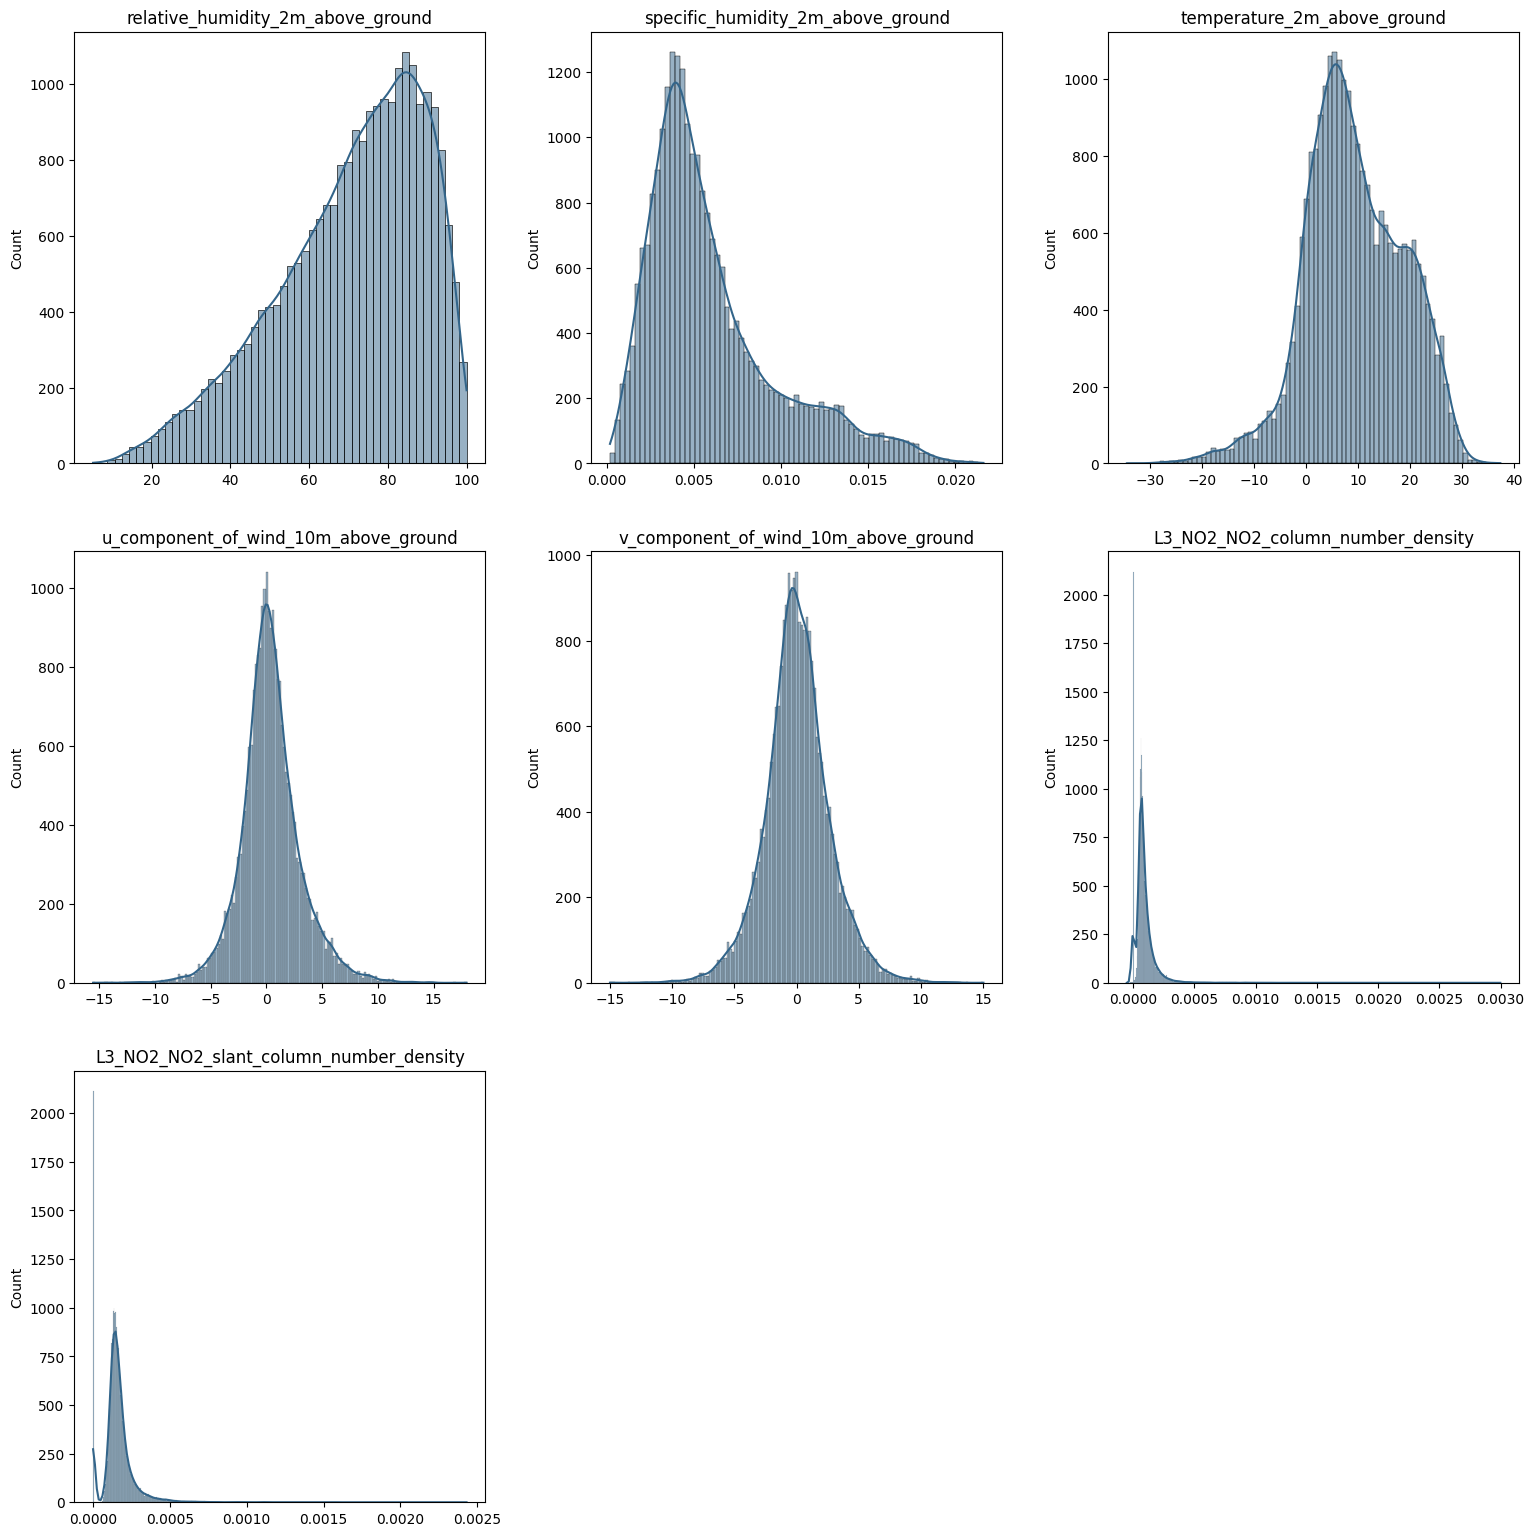

In [296]:
# plot features (max 7) 
%run histogram_9_features.ipynb

to_plot = train_X.columns[3:11]
plot_histograms(train_X[to_plot], train_X)

## Mary Model

In [297]:
# Impute missing value with imputer class
%run interpolation_imputer.ipynb

In [298]:
# Remove outlier class
%run outlier_zscore.ipynb

In [395]:
# Log transformer class
%run log_transformer.ipynb

**Preprocessing**

In [448]:
# columns with outliers
outlier_columns = ['L3_NO2_NO2_column_number_density',
                'L3_NO2_NO2_slant_column_number_density',
                'L3_NO2_sensor_altitude',
                'L3_NO2_solar_zenith_angle',
                'L3_NO2_stratospheric_NO2_column_number_density',
                'L3_NO2_tropospheric_NO2_column_number_density',
                'L3_O3_O3_effective_temperature',
                'L3_CO_CO_column_number_density',
                'L3_CO_H2O_column_number_density', 
                'L3_CO_sensor_altitude',
                'L3_CLOUD_cloud_optical_depth']

In [449]:
# columns with skewed n. distr. (may not relevant as no big effect on non-skewed so simply applied for every column)
skewed_columns = ['precipitable_water_entire_atmosphere',
                  'relative_humidity_2m_above_ground',
                  'specific_humidity_2m_above_ground',
                  'L3_CO_H2O_column_number_density',
                  'L3_CLOUD_cloud_top_height', 
                  'L3_CLOUD_cloud_top_pressure',
                  'L3_SO2_SO2_column_number_density_amf']

In [450]:
# columns with outlier
outliers = Pipeline(steps=[
    ('imputing', InterpolationImputer()),
    ('log_transform', LogTransformer()),
    ('outlier', ReplaceOutliersWithMean()), 
    ('standard_scaler', StandardScaler())
])

In [451]:
# columns with skewed dist
skewed = Pipeline(steps=[
    ('imputing', InterpolationImputer()),
    ('log_transform', LogTransformer()), 
    ('standard_scaler', StandardScaler())
])

In [452]:
# columns wout outliers
non_outliers = Pipeline(steps=[
    ('imputing', InterpolationImputer()),
    ('standard_scaler', StandardScaler()) 
])

In [453]:
preprocessing = ColumnTransformer([
    ('outliers', outliers, outlier_columns), 
    ('skewed', skewed, skewed_columns),    
    ('non_outliers', non_outliers, train_X.columns.drop(['Place_ID', 'Date'] + outlier_columns + skewed_columns).tolist())
])

**Features - Analysis of Variance (ANOVA)**

ANOVA cos numerical continous variables

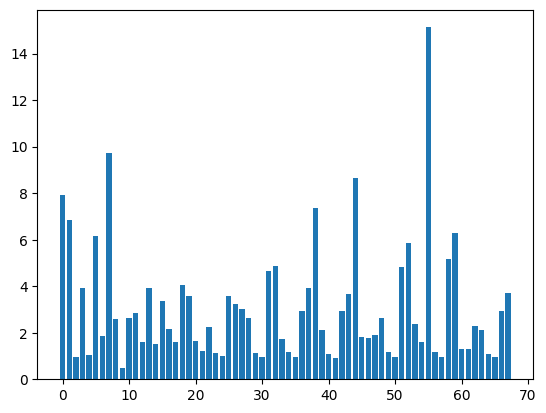

In [481]:
# only works without log_transform
preprocessing_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('anova_feature_selection', SelectKBest(score_func=f_classif, k=28))

])

preprocessing_pipeline.fit(train_X, train_y)
X_transformed = preprocessing_pipeline.named_steps['preprocessing'].transform(train_X)

# Get ANOVA scores
anova_scores = preprocessing_pipeline.named_steps['anova_feature_selection'].scores_

# Plot
plt.bar([i for i in range(len(anova_scores))], anova_scores)
plt.show()

**Stacking and Boosting**

In [478]:
# stacking of heterogenous weak learners and xgboost
estimators_stacking = [
    ('lg', LinearRegression()),   
    ('knn', KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto', leaf_size=20, p=2)), 
    ('rf', RandomForestRegressor(random_state=RSEED, max_depth=2, n_estimators=30))
]

final_estimator = XGBRegressor(n_estimators = 30, max_depth = 5, random_state = 13)

stacking_boost = Pipeline([
    ('preprocessor', preprocessing),
    ('feature_selection', SelectKBest(score_func=f_classif, k = 50)),
    ('stacking', StackingRegressor(estimators = estimators_stacking, final_estimator = final_estimator))
])

In [479]:
stacking_boost.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('outliers',
                                                  Pipeline(steps=[('imputing',
                                                                   InterpolationImputer()),
                                                                  ('log_transform',
                                                                   LogTransformer()),
                                                                  ('outlier',
                                                                   ReplaceOutliersWithMean()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['L3_NO2_NO2_column_number_density',
                                                   'L3_NO2_NO2_slant_column_number_density',
                                                   'L3_NO2_sensor_altitude',
                                                   'L3_NO2_...
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=None,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=5,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=30,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=13, ...)))])

In [480]:
y_train_predicted = stacking_boost.predict(train_X)
print("RMSE: {:.2f}".format(mean_squared_error(train_y, y_train_predicted, squared=False)))

y_test_predicted = stacking_boost.predict(test_X)
print("RMSE: {:.2f}".format(mean_squared_error(test_y, y_test_predicted, squared=False)))

RMSE: 30.77
RMSE: 31.93


**Random Search**

In [456]:
# parameter distribution

param_dist = {
#    'stacking__dt__fit_intercept': [True, False],  # LinearRegression
    'stacking__knn__n_neighbors': randint(1, 10),   # KNeighborsRegressor
    'stacking__rf__n_estimators': randint(50, 200),  # RandomForestRegressor
    'stacking__rf__max_depth': randint(3, 10)  # RandomForestRegressor
}

# Create a random search object
random_search = RandomizedSearchCV(stacking_boost, param_distributions=param_dist, n_iter=5, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Train
random_search.fit(train_X, train_y)

# Print the best parameters and the corresponding performance metric
print("Best Parameters: ", random_search.best_params_)
print("Best Score: ", random_search.best_score_)

# Use the best model from random search
random_ensemble_boost = random_search.best_estimator_

Best Parameters:  {'stacking__knn__n_neighbors': 1, 'stacking__rf__max_depth': 9, 'stacking__rf__n_estimators': 52}
Best Score:  -1106.9961446385835


**Predicting and Evaluating**

In [458]:
y_train_predicted = random_ensemble_boost.predict(train_X)
print("RMSE: {:.2f}".format(mean_squared_error(train_y, y_train_predicted, squared=False)))

y_test_predicted = random_ensemble_boost.predict(test_X)
print("RMSE: {:.2f}".format(mean_squared_error(test_y, y_test_predicted, squared=False)))

RMSE: 22.92
RMSE: 31.49


In [ ]:
#RMSE: 28.50
#RMSE: 32.35

**Baggging and Boosting**

In [70]:
# bagging of homogenous weak learners and xgboost
estimators_bagging = [
    ('rf1', RandomForestRegressor(random_state=9, max_depth=5)),
    ('rf2', RandomForestRegressor(random_state=13, max_depth=5)),
    ('rf3', RandomForestRegressor(random_state=42, max_depth=5))
]

final_estimator = XGBRegressor(n_estimators = 31, max_depth = 3, random_state = 13)

bagging_boost = Pipeline([
    ('preprocessor', preprocessing),
    ('stacking', StackingRegressor(estimators = estimators_bagging, final_estimator = final_estimator))
])

In [71]:
bagging_boost.fit(train_X, train_y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('outliers',
                                                  Pipeline(steps=[('imputing',
                                                                   InterpolationImputer()),
                                                                  ('outlier',
                                                                   ReplaceOutliersWithMean()),
                                                                  ('standard_scaler',
                                                                   StandardScaler())]),
                                                  ['L3_NO2_NO2_column_number_density',
                                                   'L3_NO2_NO2_slant_column_number_density',
                                                   'L3_NO2_sensor_altitude',
                                                   'L3_NO2_solar_zenith_angle',
                                                   'L3_NO2_stratos...
                                                                gamma=None,
                                                                grow_policy=None,
                                                                importance_type=None,
                                                                interaction_constraints=None,
                                                                learning_rate=None,
                                                                max_bin=None,
                                                                max_cat_threshold=None,
                                                                max_cat_to_onehot=None,
                                                                max_delta_step=None,
                                                                max_depth=3,
                                                                max_leaves=None,
                                                                min_child_weight=None,
                                                                missing=nan,
                                                                monotone_constraints=None,
                                                                multi_strategy=None,
                                                                n_estimators=31,
                                                                n_jobs=None,
                                                                num_parallel_tree=None,
                                                                random_state=13, ...)))])

In [73]:
y_train_predicted = bagging_boost.predict(train_X)
print("RMSE: {:.2f}".format(mean_squared_error(train_y, y_train_predicted, squared=False)))

y_test_predicted = bagging_boost.predict(test_X)
print("RMSE: {:.2f}".format(mean_squared_error(test_y, y_test_predicted, squared=False)))

RMSE: 36.74
RMSE: 36.39


In [ ]:
# with removing outliers but SimpleImputation
# RMSE: 30.06
# RMSE: 32.18

# with removing outliers but own defined Imputer
# RMSE: 30.50
# RMSE: 32.65